In [17]:
import sys
import os
import glob
import random
import copy
from IPython.display import display, Markdown
sys.path.append('../..')

from model import processing
from matplotlib import pyplot as plt

from model import run
from model import plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, value_assets, usd_price, lrna_price
from model.amm.stableswap_amm import StableSwapPoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)
# price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2023', days = 120)

assets = {
    'USDA': {'usd price': 1, 'weight': 0.50},
    'USDB': {'usd price': 1, 'weight': 0.50}
}

assert sum([t['weight'] for t in assets.values()]) == 1

initial_tvl = 1000000

initial_state = GlobalState(
    pools={
        'stableswap': StableSwapPoolState(
            tokens={
                tkn: initial_tvl * assets[tkn]['weight'] for tkn in assets
            },
            amplification=100,
            trade_fee=0
        )
    },
    agents = {
        'Trader': Agent(
            holdings={tkn: 10000000000000 for tkn in assets}
        )
    },
    # external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    # archive_all=False
)

In [18]:
amps = [12.5, 200, 40000]
amps = [10, 20, 50, 75, 100, 150, 200]
# amps=[1000]
amps.sort()  # required
max_trade = 400000
steps = 100
max_i = 1000
price_band = 0.1
amp_events = []
amounts = []
spot_prices = []
for i, amplification in enumerate(amps):
    initial_state.pools['stableswap'].amplification = amplification
    trade_size_min, trade_size_max = -max_trade, max_trade
    trade_sizes = [trade_size_min + i * (trade_size_max - trade_size_min) / steps for i in range(steps)]
    events = []
    
    step_size = 1000
    trade_size = 0
    spot_price = 1
    i = 0
    amts = []
    prices = []
    # for trade_size in trade_sizes:
    while spot_price <= 1 + price_band and i < max_i:
        i += 1
        # trade to change the price of assets. 
        # We assume that whatever the resulting price is the new market price, and the trade is an arb trade.
        trade_state = copy.deepcopy(initial_state)
        
        
        
        post_event = run.run(trade_state, time_steps=1, silent=True)[-1].execute_swap(
                pool_id='stableswap',
                agent_id='Trader',
                tkn_sell='USDB',
                tkn_buy='USDA',
                buy_quantity=max(abs(trade_size), 0),
            )
        
        events.append(post_event)
        
        spot_price = 1 / post_event.pools['stableswap'].spot_price()
        prices.append(spot_price)
        amts.append(post_event.pools['stableswap'].liquidity['USDA'])
        
        trade_size += step_size
        
    trade_size = step_size
    i = 0
    while spot_price >= 1 - price_band and i < max_i:
        i += 1
        # trade to change the price of assets. 
        # We assume that whatever the resulting price is the new market price, and the trade is an arb trade.
        trade_state = copy.deepcopy(initial_state)
        
        post_event = run.run(trade_state, time_steps=1, silent=True)[-1].execute_swap(
                pool_id='stableswap',
                agent_id='Trader',
                tkn_sell='USDA',
                tkn_buy='USDB',
                sell_quantity=max(abs(trade_size), 0),
            )
        
        events.append(post_event)
        
        spot_price = 1 / post_event.pools['stableswap'].spot_price()
        prices.append(spot_price)
        amts.append(post_event.pools['stableswap'].liquidity['USDA'])
        
        trade_size += step_size
    
    spot_prices.append(prices)
    amounts.append(amts)
    


    amp_events.append(copy.deepcopy(events))
    
print('simulation finished.')

simulation finished.


In [19]:
tenth_percentile = []
twentieth_percentile = []
eightieth_percentile = []
ninetieth_percentile = []
for i, amp in enumerate(amps):
    amt_ls = amounts[i]
    price_ls = spot_prices[i]
    pairs = [(spot_prices[i][j], amounts[i][j]) for j in range(len(amounts[i]))]
    pairs.sort(key=lambda pair: pair[0])
    amt_ls = [pair[1] for pair in pairs]
    price_ls = [pair[0] for pair in pairs]
    tenth = []
    twentieth = []
    eightieth = []
    ninetieth = []
    for j in range(len(amt_ls) - 1):
        if amt_ls[j] >= 900000 and amt_ls[j+1] < 900000:
            ninetieth.append((price_ls[j], amt_ls[j]))
        if amt_ls[j] >= 800000 and amt_ls[j+1] < 800000:
            eightieth.append((price_ls[j], amt_ls[j]))
        if amt_ls[j] >= 200000 and amt_ls[j+1] < 200000:
            twentieth.append((price_ls[j], amt_ls[j]))
        if amt_ls[j] >= 100000 and amt_ls[j+1] < 100000:
            tenth.append((price_ls[j], amt_ls[j]))
            break
    tenth_percentile.append(tenth)
    twentieth_percentile.append(twentieth)
    eightieth_percentile.append(eightieth)
    ninetieth_percentile.append(ninetieth)

print('90th percentile: ')

90th percentile: 


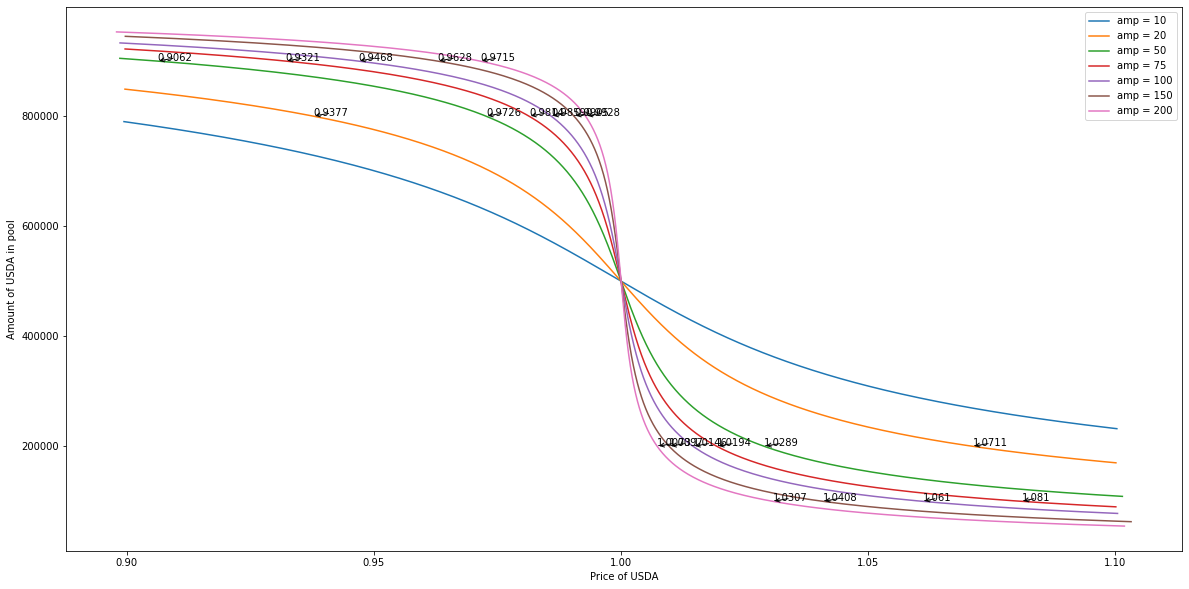

In [20]:

    
plt.figure(figsize=(20,10))

for i in range(len(amounts)):
    pairs = [(spot_prices[i][j], amounts[i][j]) for j in range(len(amounts[i]))]
    pairs.sort(key=lambda pair: pair[0])
    plt.plot([pair[0] for pair in pairs], [pair[1] for pair in pairs], label=f'amp = {amps[i]}')
    for pair in tenth_percentile[i]:
        plt.annotate(
            xy=pair,
            xytext=(pair[0], pair[1]),
            text=f"{round(pair[0], 4)}",
            arrowprops={'arrowstyle': '->', 'relpos': (0.5, 0.5)}
        )
    for pair in twentieth_percentile[i]:
        plt.annotate(
            xy=pair,
            xytext=(pair[0], pair[1]),
            text=f"{round(pair[0], 4)}",
            arrowprops={'arrowstyle': '->', 'relpos': (0.5, 0.5)}
        )
    for pair in eightieth_percentile[i]:
        plt.annotate(
            xy=pair,
            xytext=(pair[0], pair[1]),
            text=f"{round(pair[0], 4)}",
            arrowprops={'arrowstyle': '->', 'relpos': (0.5, 0.5)}
        )
    for pair in ninetieth_percentile[i]:
        plt.annotate(
            xy=pair,
            xytext=(pair[0], pair[1]),
            text=f"{round(pair[0], 4)}",
            arrowprops={'arrowstyle': '->', 'relpos': (0.5, 0.5)}
        )
    
plt.legend()
plt.xlabel("Price of USDA")
plt.ylabel("Amount of USDA in pool")

plt.show()

